# Quantum Phase Estimation for the $H_{2}$ Molecule

**Petar Samardžić**

**17/12/2025**

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from qat.qpus import PyLinalg 
from qat.lang.AQASM import Program, QRoutine, H, RX, RZ, CNOT, AbstractGate
from qat.lang.AQASM.qftarith import IQFT
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo

## Modelisation of the Dihydrogen Molecule

The goal of this project is to compute, using quantum phase estimation, the lowest eigenvalue $E_0$ of a symmetric matrix $H$, stemming from quantum chemistry. In this example, the matrix $H$ comes from the discretisation of an elliptic operator describing the behaviour of the dihydrogen ($H_{2}$) molecule.

The following code enables to retrieve the matrix $H$ as a sum:

$$
H = \sum_{k=1}^{K} c_{k} P_{k}, \qquad(1)
$$

where $(c_{k})_{1\leq k \leq K}$ are real coefficients and $(P_{k})_{1\leq k \leq K} \in \mathbb{C}^{2^4 \times 2^4}$ is of the form $A_{1} \otimes A_{2} \otimes A_{3} \otimes A_{4}$ where $(A_{i})_{1\leq i \leq 4}$ is a Pauli matrix $X$, $Y$ or $Z$.

In [2]:
h2_data = np.load("h2_data.npz", allow_pickle=True)

rdm1 = h2_data["rdm1"]
orbital_energies = h2_data["orbital_energies"]
nuclear_repulsion = h2_data["nuclear_repulsion"]
n_electrons = h2_data["n_electrons"]
one_body_integrals = h2_data["one_body_integrals"]
two_body_integrals = h2_data["two_body_integrals"]
info = h2_data["info"].tolist()

nqbits = rdm1.shape[0] * 2

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
hamiltonian = mol_h.get_electronic_hamiltonian()  
hamiltonian_qubit = hamiltonian.to_spin()

In [3]:
print(f"Number of qubits = {nqbits}")
print(hamiltonian_qubit)

Number of qubits = 4
(-0.09886396606238182+0j) * I^4 +
(0.1686221915+0j) * (ZZ|[0, 1]) +
(0.12054482200000001+0j) * (ZZ|[0, 2]) +
(0.165867024+0j) * (ZZ|[1, 2]) +
(0.165867024+0j) * (ZZ|[0, 3]) +
(0.17119774749999997+0j) * (Z|[0]) +
(0.12054482200000001+0j) * (ZZ|[1, 3]) +
(0.1711977475+0j) * (Z|[1]) +
(0.045322202+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844175+0j) * (ZZ|[2, 3]) +
(-0.22278593024999999+0j) * (Z|[2]) +
(-0.22278593024999999+0j) * (Z|[3])


The Hamiltonian of interest in this project is `hamiltonian_qubit`, which is a Python object containing the information on the electronic Hamiltonian as a sum of Pauli matrices. More precisely, it contains the attribute `terms` containing all the terms of the sum from Equation (1). More precisely, `hamiltonian_qubit.terms` is an array of size $K$ where, for each $1 \leq k \leq K$, `hamiltonian_qubit.terms[k]` corresponds to the $k$-th term in that sum. Moreover,
- `hamiltonian_qubit.terms[k].coeff` gives the coefficient $c_{k}$ from the sum
- `hamiltonian_qubit.terms[k].op` is the string corresponding to the Pauli operators appearing in $P_{k}$
- `hamiltonian_qubit.terms[k].qbits` gives the list of the qubits on which $P_{k}$ is different from the identity.

For example:

In [4]:
print(hamiltonian_qubit.terms[1]) 

Term(qbits=[0, 2], op='ZZ', _coeff=TNumber(is_abstract=False, type=5, int_p=None, double_p=None, string_p=None, matrix_p=None, serialized_p=None, complex_p=ComplexNumber(re=np.float64(0.12054482200000001), im=np.float64(0.0))), _do_validity_check=True)


This term corresponds to $0.120544822 Z_{0} Z_{2}$ where $Z_{0} = Z \otimes I_{2} \otimes I_{2} \otimes I_{2}$ and $Z_{2} = I_{2} \otimes I_{2} \otimes Z \otimes I_{2}$.

## Quantum Phase Estimation

### Trotter Splitting

Because we have the Hamiltonian $H$ in the form of a sum of Pauli gates, the unitary matrix $e^{-iHt}$ for $t \in \mathbb{R}$ cannot be implemented exactly using the common gates available in MyQLM. Fortunately, for each term $P_{k}$ in Equation (1), there is an exact implementation of the rotation $e^{-i \frac{\theta}{2} P_{k}}$ given by the function `construct_Pauli_evolution` below.

In [5]:
def construct_Pauli_evolution(ops, qbits, theta):
    """
    Implements the quantum routine
    
    .. math::
        R_{k}(\theta) = e^{-i \frac{\theta}{2} P_{k}}
         
    with P_{k} a Pauli string
    
    Args:
        ops (str): Pauli operators (e.g X, Y, ZZ, etc.)
        qbits (list<int>): qubits on which they act
        theta (Variable): the abstract variable
        
    Returns:
        QRoutine
        
    Notes:
        the indices of the wires of the QRoutine are relative 
        to the smallest index in qbits (i.e always start at qb=0)
    """

    qrout = QRoutine()
    qreg = qrout.new_wires(len(qbits))

    with qrout.compute():
        for op, qbit in zip(ops, qreg):
            if op == "X":
                qrout.apply(H, qbit)
            if op == "Y":
                qrout.apply(RX(np.pi/2), qbit)
        for ind_qb in range(len(qreg)-1):
            qrout.apply(CNOT, qreg[ind_qb], qreg[ind_qb+1])
    qrout.apply(RZ(theta.real), qreg[-1])
    qrout.uncompute()
    
    return qrout

The evolution $e^{-iHt}$ can then be approximated by successive short evolutions of the form $e^{-i P_k t/n}$:

$$
e^{-iHt} \simeq  (\prod_{k=1}^{K} e^{-i P_{k} \frac{t}{n}})^{n}, \qquad (2)
$$ 

where $n \in \mathbb{N}$. This is called a **Trotter splitting** and one can show that:

$$
\|e^{-iHt} - (\prod_{k=1}^{K} e^{-i P_{k} \frac{t}{n}})^{n}\| = \mathcal{O}(\frac{1}{n}), \qquad(3)
$$

### Controlled-U Rotation

In this part, an approximation of the controlled Hamiltonian evolution is implemented, based on the Trotter splitting above. Realising that for $U,V$ two unitaries, we have:

$$
\mathrm{C}-(UV) = (\mathrm{C}-(U)) (\mathrm{C}-(V)), \qquad (4)
$$

We have the following implementation of the controlled evolution.

In [6]:
def make_controlled_evolution(hamiltonian, t0, n_trotter):
    """
    Contructs an approximation of C-U, where
    
    .. math::
        U \\simeq e^{-i H t0)

    Args:
        hamiltonian (Observable): the Hamiltonian H
        t0 (float): the evolution time
        n_trotter (int): the number of Trotter slices

    Returns:
        QRoutine: the U routine
    """

    routine = QRoutine()
    anc_reg = routine.new_wires(1)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    routine.apply(RZ(-hamiltonian.constant_coeff.real*t0), anc_reg)
    
    for _ in range(n_trotter):
        for term in hamiltonian.terms:
            theta = t0/n_trotter*2*term.coeff 
            Rk_routine = construct_Pauli_evolution(term.op, term.qbits, theta)
            
            routine.apply(Rk_routine.ctrl(), anc_reg, [data_reg[qb] for qb in term.qbits])

    return routine

### QPE Routine

The QPE algorithm estimates the eigenvalues of a unitary operator by performing three main steps:
- Hadamard gates prepare the phase registers
- Controlled applications of the unitary operator encode the phase information
- An inverse quantum Fourier transform (IQFT) extracts the phase into the computational basis for measurement

We have the following implementation of the QPE routine.

In [7]:
def build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=1.0, n_trotter=1):
    """
    Constructs the QPE routine corresponding to a given Hamiltonian
    
    Args:
        hamiltonian (Observable): a Hamiltonian
        n_phase_bits (int): the number of phase bits
        t0 (float): the evolution time
        n_trotter (int): the number of Trotter steps
        
    Returns:
        QRoutine: a quantum routine for phase estimation with unitary U = exp(-i H t0)
    """

    routine = QRoutine()
    phase_reg = routine.new_wires(n_phase_bits)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    for qb in phase_reg:
        routine.apply(H, qb)

    for k, qb in enumerate(phase_reg):
        Uk = make_controlled_evolution(hamiltonian, t0 * (2 ** k), n_trotter)
        routine.apply(Uk, qb, data_reg)

    routine.apply(IQFT(len(phase_reg)), phase_reg)

    return routine

### Repeated Testing Framework

The `perform_qpe` function prepares the initial state by combining the given eigenvector with a phase register, applies the QPE routine, and then measures the phase register. It effectively repeats the QPE experiment `nbshots` times to estimate the probability distribution of the phase outcomes, returning the frequencies of each possible measurement result.

In [8]:
StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray]) 

def perform_qpe(qpu, hamiltonian, psi0, n_phase_bits, n_trotter=10, nbshots=1000, t0=1.0):
    """
    Constructs the repeated testing framework for QPE
    
    Args:
        qpu (QPU): a QPU
        hamiltonian (Observable): a Hamiltonian
        psi0 (np.array): an eigenvector of H
        n_phase_bits (int): number of bits for the phase
        n_trotter (int, optional): number of trotter slices. Defaults to 10
        nbshots (int, optional): number of shots. Defaults to 1000
        t0 (float, optional): time in U = exp(- i H t0). Defaults to 1
        
    Returns:
        np.array: the vector of probabilities (frequencies) of obtaining each output (from 0 to 2^{m-1})
    """
    
    phase_reg_in = np.zeros((2 ** n_phase_bits,))
    phase_reg_in[0] = 1.0
    psi_init = np.kron(phase_reg_in, psi0) 
    
    prog = Program()
    phase_reg = prog.qalloc(n_phase_bits)
    data_reg = prog.qalloc(hamiltonian.nbqbits)

    prog.apply(StatePreparation(psi_init), phase_reg, data_reg)

    pea_routine = build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=t0, n_trotter=n_trotter)
    prog.apply(pea_routine, phase_reg, data_reg)
    
    circ = prog.to_circ()
    circ_job = circ.to_job(nbshots=nbshots, qubits=phase_reg)
    res = qpu.submit(circ_job)

    probs = np.zeros(2**n_phase_bits)
    for sample in res:
        probs[sample.state.int] = sample.probability

    return probs

## Results

In order to apply QPE to find the estimation of the ground state energy, we need a good input state (namely a state with a large overlap with the ground state). For now, we will assume our input state is the ground state itself.

We also need to make sure that the phase estimated by QPE for the unitary matrix $e^{-i (H-\tilde{E}) t}$ is in the $[0, 1)$ interval. If we know that $E_{0}$ is within an energy window $[E_{min},E_{max}]$, then a shift $\tilde{E} = E_{max}$ and $t = \frac{2\pi}{E_{max} - E_{min}}$ will achieve this condition. After we get the results, we must invert these operations in order to get the actual desired values.

### Expected Results

For comparison, let us solve the problem exactly: since it is a small eigenvalue problem, we can afford to diagonalise the corresponding Hamiltonian exactly using classical methods.

In [9]:
eigvals, eigvecs = np.linalg.eigh(hamiltonian_qubit.get_matrix())
psi0 = eigvecs[:, np.argmin(eigvals)]

exp_E0 = min(eigvals)

additional_spread = 1.0
Emin = exp_E0 - additional_spread
Emax = max(eigvals) + additional_spread

hamiltonian_qubit_offset = hamiltonian_qubit - Emax
t0 = 2*np.pi / (Emax - Emin)

all_phases = (Emax - eigvals) / (Emax - Emin)
exp_phase = max(all_phases)

In [10]:
print(f"Expected phase = {exp_phase}")
print(f"Expected energy = {exp_E0}")

Expected phase = 0.7535353440247669
Expected energy = -1.137270167926503


### Obtained Measurements

In [11]:
qpu = PyLinalg()
n_phase_bits = 6
n_trotter = 40

probs = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, n_phase_bits, n_trotter=n_trotter, t0=t0)

phase = np.argmax(probs) / 2**n_phase_bits
E0 = - phase * (Emax - Emin) + Emax

In [12]:
print(f"Phase = {phase}")
print(f"Energy = {E0}")

Phase = 0.75
Energy = -1.1229259447729725


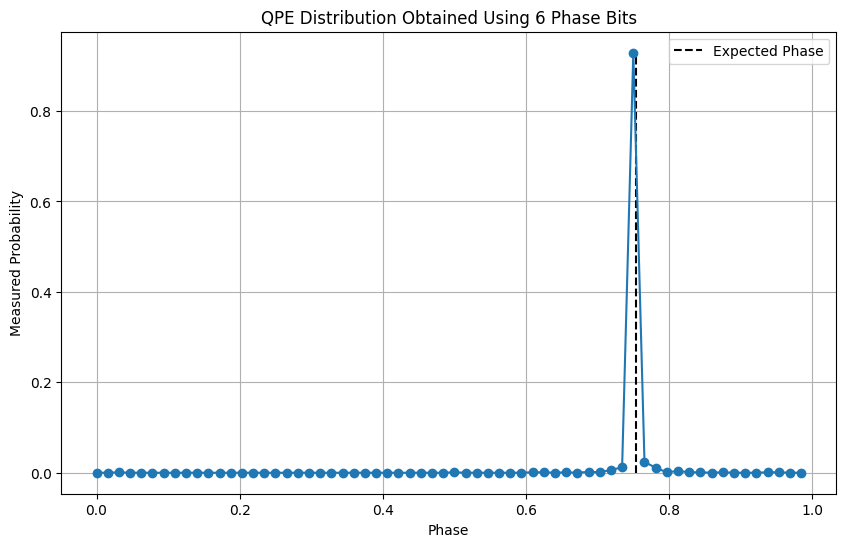

In [13]:
plt.figure(figsize=(10,6))
plt.plot([exp_phase, exp_phase], [0, np.max(probs)], '--k', label = "Expected Phase")
plt.plot(np.linspace(0, 1, 2**n_phase_bits, endpoint=False), probs, '-o')

plt.legend()
plt.title(f"QPE Distribution Obtained Using {n_phase_bits} Phase Bits")
plt.xlabel("Phase")
plt.ylabel("Measured Probability")
plt.grid()
plt.show()

The QPE experiment yields values for the phase and energy which are in close agreement with the expected values. The probability distribution of the phase measurements is sharply peaked around the expected phase, with borderline negligible probability elsewhere, confirming that the algorithm correctly identifies the target eigenvalue with high confidence. The small discrepancies are consistent with finite Trotterization and the limited number of phase bits.

We can also notice the accuracy constrictions produces by the number of phase bits: by multiplying the expected phase by 2 to the power of `n_phase_bits` produces an integer.

## Potential improvements

### Increasing the Number of Phase Bits

Our results are limited by the number of phase bits, as the output can only be in the increments of 2 to the power of the number of phase bits. Hence, increasing that number will surely improve our measurements.

In [14]:
phase_bits_list = range(4,11)
errors_phase_bits = []

for phase_bits in phase_bits_list:
    probs_phase_bits = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, phase_bits, n_trotter=n_trotter, t0=t0)
    errors_phase_bits.append(abs(np.argmax(probs_phase_bits) / 2**phase_bits - exp_phase))

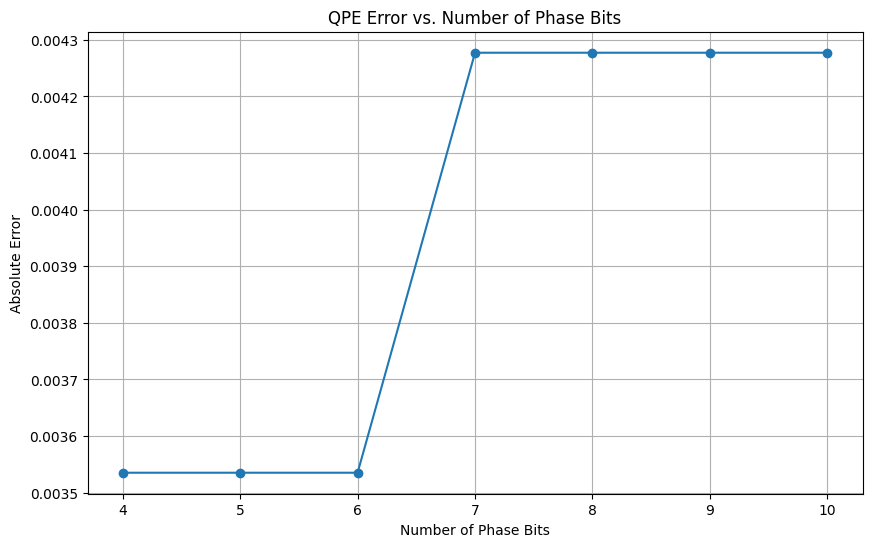

In [15]:
plt.figure(figsize=(10,6))
plt.plot(phase_bits_list, errors_phase_bits, '-o')

plt.title('QPE Error vs. Number of Phase Bits')
plt.xlabel('Number of Phase Bits')
plt.ylabel('Absolute Error')
plt.grid()
plt.show()

It seems like there is a point of diminishing returns. This seems counterintuitive, as increasing the number of phase bits should objectively improve our measurements. A possible explanation is that the majority of our error comes from other sources. In general, an error could show up due multiple reasons, e.g.:
- Poor input state
- Approximation error from Trotter splitting
- Numerical errors
- etc.

### Increasing the number of Trotter steps

Given our idealized circumstances, our main suspect is the error from Trotter splitting. Let's see what happens to our error if we keep the number of phase bits fixed, but increase `n_trotter`.

In [16]:
trotter_list = list(range(20,91,10))
errors_trotter = []

for trotter in trotter_list:
    probs_trotter = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, n_phase_bits, n_trotter=trotter, t0=t0)
    errors_trotter.append(abs(np.argmax(probs_trotter) / 2**n_phase_bits - exp_phase))

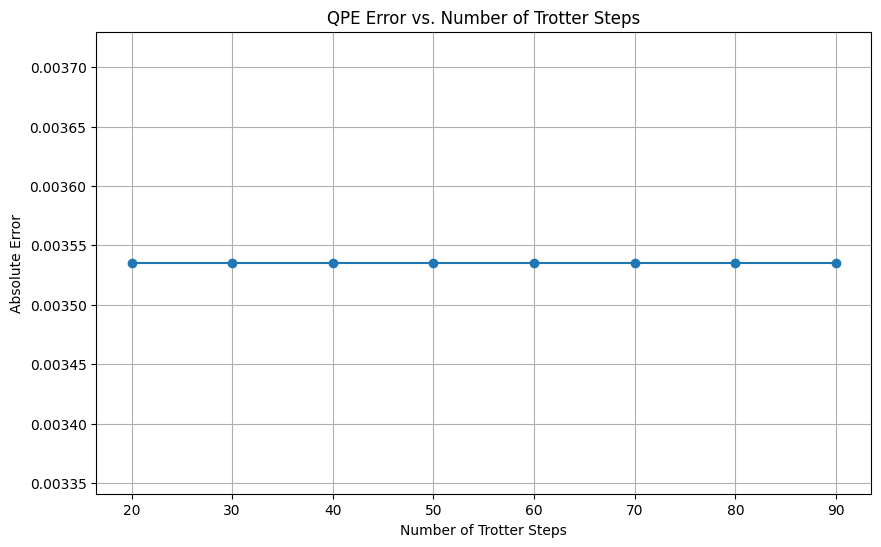

In [17]:
plt.figure(figsize=(10,6))
plt.plot(trotter_list, errors_trotter, '-o')

plt.title('QPE Error vs. Number of Trotter Steps')
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Absolute Error')
plt.grid()
plt.show()

Again, very quickly we get diminishing returns (more precisely, constant errors). This is due to the discrete nature of our output. The correct next move is to combine the previous two approaches.

### Increasing Both the Number of Phase Bits and the Number of Trotter Steps

Let's find how the error changes if we vary both parameters.

In [18]:
phase_bits_list = range(4,11,2)
trotter_list = range(20,91,20)
errors = []
timings = []

for i in range(len(trotter_list)):
    errors.append([])
    timings.append([])

    for phase_bits in phase_bits_list:
        start_time = time.time()

        probs_phase_bits = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, phase_bits, n_trotter=trotter_list[i], t0=t0)
        errors[i].append(abs(np.argmax(probs_phase_bits) / 2**phase_bits - exp_phase))

        end_time = time.time()
        timings[i].append(end_time - start_time)


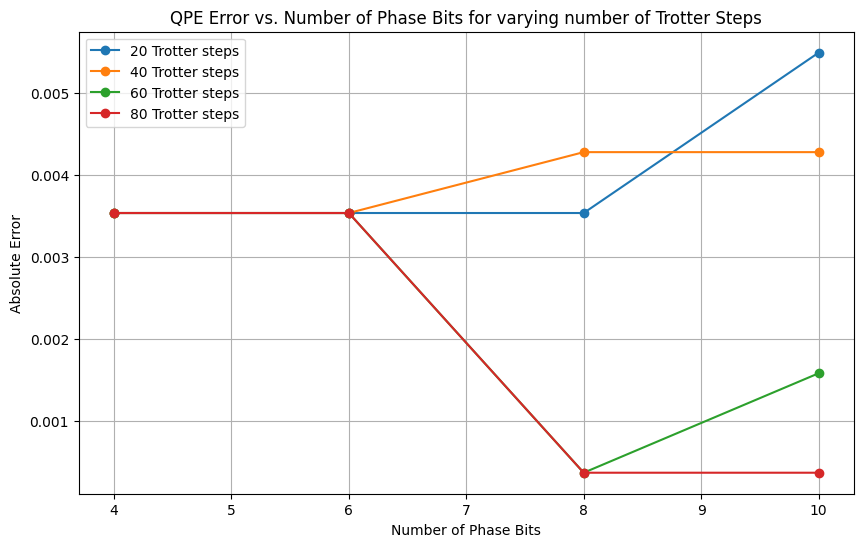

In [19]:
plt.figure(figsize=(10,6))

for i in range(len(trotter_list)):
    plt.plot(phase_bits_list, errors[i], '-o', label=f'{trotter_list[i]} Trotter steps')

plt.legend()
plt.title('QPE Error vs. Number of Phase Bits for varying number of Trotter Steps')
plt.xlabel('Number of Phase Bits')
plt.ylabel('Absolute Error')
plt.grid()
plt.show()

As we see, it pays off to increase both parameters. One thing to keep in mind is the exponential increase in time required to produce the result.

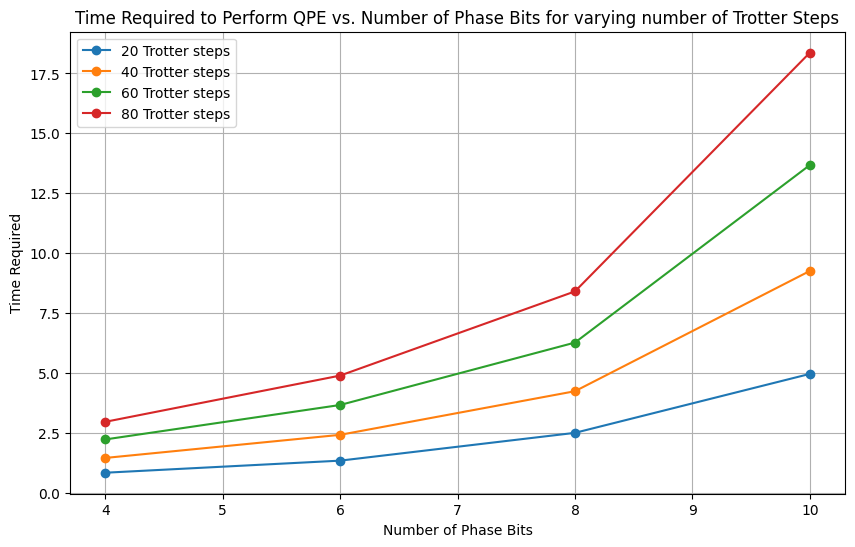

In [20]:
plt.figure(figsize=(10,6))

for i in range(len(trotter_list)):
    plt.plot(phase_bits_list, timings[i], '-o', label=f'{trotter_list[i]} Trotter steps')

plt.legend()
plt.title('Time Required to Perform QPE vs. Number of Phase Bits for varying number of Trotter Steps')
plt.xlabel('Number of Phase Bits')
plt.ylabel('Time Required')
plt.grid()
plt.show()

Ideally, we're looking for a trade-off between the required time and accuracy.

### Maximum Likelihood Estimation

So far, we have defined our measurement by taking the output with the highest measured probability (the most realised outcomes). This limits our output to discrete increments, leading to increased algorithm error. Instead, we can try and improve our results by applying the MLE methodology to our probability distribution.

We have the following implementation of MLE for QPE.

In [21]:
def qpe_mle(probs, n_grid=10000):
    """
    Estimates the phase from a realized probability distribution using MLE
    
    Args:
        probs (np.array): realized probability distribution
        n_grid (int): number of points for grid search. Defaults to 10000
        
    Returns:
        float: MLE estimate of the phase in [0,1)
    """

    n_entries = len(probs)
    grid_points = np.linspace(0, 1, n_entries, endpoint=False)

    thetas = np.linspace(0, 1, n_grid, endpoint=False)
    ll = np.zeros_like(thetas)

    for i in range(len(thetas)):
        num = np.abs(np.sin((n_entries) * np.pi * thetas[i]))
        num = np.where(num < 1e-12, 1e-12, num)
        den = np.abs(np.sin(np.pi * (thetas[i] - grid_points)))
        den = np.where(den < 1e-12, 1e-12, den)
        ll[i] = np.sum(probs * np.log(num / den))

    return thetas[np.argmax(ll)]


Let's see how our MLE prediction compares to just taking the highest entry.

In [22]:
nbshots_list = range(100, 1001, 100)
errors_MLE = []

for shots in nbshots_list:
    probs_MLE = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, n_phase_bits, n_trotter=n_trotter, nbshots = shots, t0=t0)
    errors_MLE.append(abs(qpe_mle(probs_MLE) - exp_phase))


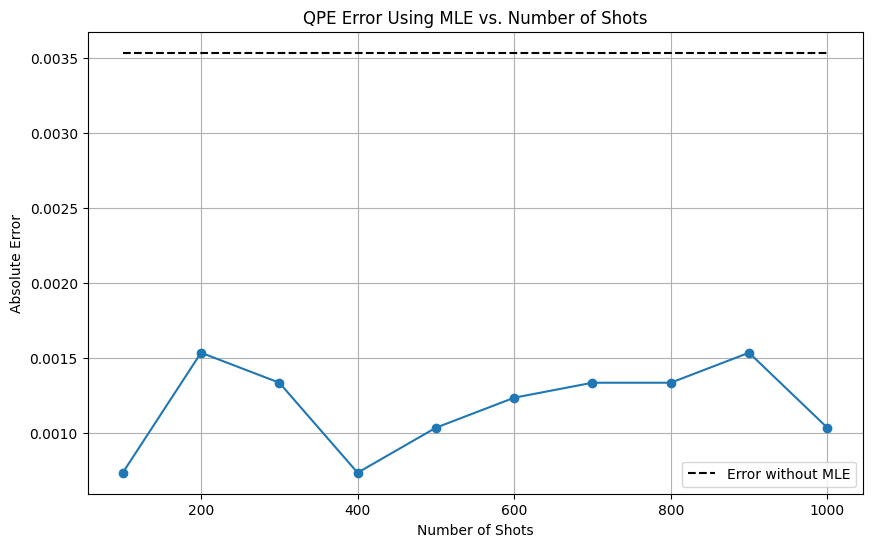

In [23]:
plt.figure(figsize=(10,6))
plt.plot([nbshots_list[0], nbshots_list[-1]], [abs(phase - exp_phase)]*2, '--k', label="Error without MLE")
plt.plot(nbshots_list, errors_MLE, '-o')

plt.legend()
plt.title('QPE Error Using MLE vs. Number of Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Absolute Error')
plt.grid()
plt.show()

As we can see, MLE led to an improvement in accuracy. The point of diminishing returns occurs very quickly. This is a consequence of our idealized assumptions, having the exact eigenvector. If we recall the probability distribution, the variance is very low. This means that even with a very small number of samples, most of them are going to be very concentrated, making MLE very convergent in a sense.

In [24]:
variance = np.sum((np.linspace(0, 1, 2**n_phase_bits, endpoint=False)**2) * probs) - np.sum(np.linspace(0, 1, 2**n_phase_bits, endpoint=False) * probs)**2

In [25]:
print(f"Variance = {variance}")

Variance = 0.0007834177246092144


Keep in mind that this is the variance of the realized probability distribution, not the actual one. However, this realized distribution was found using a large number of samples, meaning that the Glivenko-Cantelli theorem assures as that this is a good approximation.

## Realism Considerations

So far, we have used the exact eigenvector as our ground state. In practice, this might not be most realistic, as any algorithm that finds that eigenvector will have error/noise. Let's see how our results changed when, instead of the exact eigenvector $\psi_{0}$, we use a perturbed one $\psi = \frac{\psi_{0}+\varepsilon\psi_{0, \perp}}{\|\psi_{0}+\varepsilon\psi_{0, \perp}\|}$ ($\varepsilon$ being the perturbation factor).

First, let's define a function for producing perturbed vectors.

In [26]:
def perturb_vector(psi, epsilon):
    """
    Constructs a perturbed version of a vector psi
    
    Args:
        psi (np.array): original vector (normalized)
        epsilon (float): perturbation strength (small number)
        
    Returns:
        np.array: normalized perturbed vector
    """

    rand_vec = np.random.rand(len(psi)) + 1j * np.random.rand(len(psi))
    psi_perp = rand_vec - np.vdot(psi, rand_vec) * psi
    psi_perp /= np.linalg.norm(psi_perp)
    
    psi_perturbed = psi + epsilon * psi_perp
    psi_perturbed /= np.linalg.norm(psi_perturbed)
    
    return psi_perturbed

Now, let's see how the results compare when using a perturbed eigenvector by observing the absolute error while varying $\varepsilon$.

In [27]:
epsilon_list = np.arange(0.0, 1.1, 0.2).tolist()
errors_epsilon = []

for epsilon in epsilon_list:
    probs_epsilon = perform_qpe(qpu, hamiltonian_qubit_offset, perturb_vector(psi0, epsilon), n_phase_bits, n_trotter=n_trotter, t0=t0)
    errors_epsilon.append(abs(qpe_mle(probs_epsilon) - exp_phase))


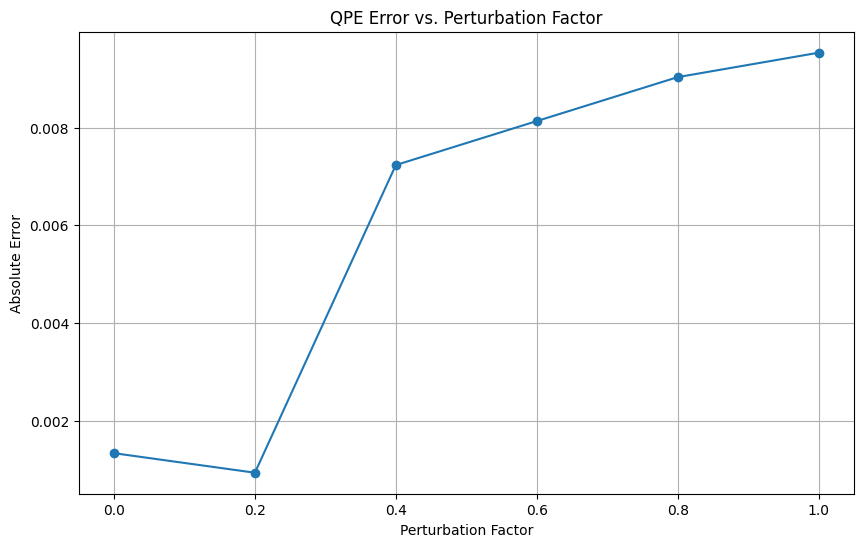

In [28]:
plt.figure(figsize=(10,6))
plt.plot(epsilon_list, errors_epsilon, '-o')

plt.title('QPE Error vs. Perturbation Factor')
plt.xlabel('Perturbation Factor')
plt.ylabel('Absolute Error')
plt.grid()
plt.show()

As we suspected, the larger the perturbation factor (or the less accurate our input vector), the larger the absolute error.

One other thing we can observe is the probability distribution for some $\varepsilon$. We will take a relatively higher value in order to magnify the effects we want to observe.

In [29]:
epsilon_perturbed = 1
psi0_perturbed = perturb_vector(psi0, epsilon_perturbed)

probs_perturbed = perform_qpe(qpu, hamiltonian_qubit_offset, psi0_perturbed, n_phase_bits, n_trotter=n_trotter, t0=t0)

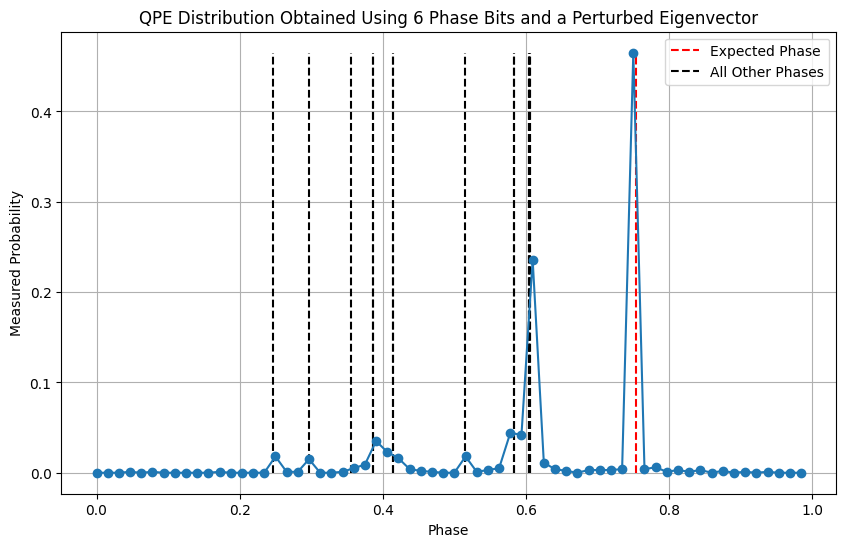

In [30]:
plt.figure(figsize=(10,6))
for phi in all_phases:
    if phi == exp_phase:
        plt.plot([phi, phi], [0, np.max(probs_perturbed)], '--r', label = "Expected Phase")
    elif phi == min(all_phases):
        plt.plot([phi, phi], [0, np.max(probs_perturbed)], '--k', label = "All Other Phases")
    else:
        plt.plot([phi, phi], [0, np.max(probs_perturbed)], '--k')

plt.plot(np.linspace(0, 1, 2**n_phase_bits, endpoint=False), probs_perturbed, '-o')

plt.legend()
plt.title(f"QPE Distribution Obtained Using {n_phase_bits} Phase Bits and a Perturbed Eigenvector")
plt.xlabel("Phase")
plt.ylabel("Measured Probability")
plt.grid()
plt.show()

As we can see the expected phase spike is less prominent, which is quite intuitive as a consequence of perturbation. Another thing to note is that we also have other spikes that seemingly coincide with other phases of our operator. This is due to the fact that our perturbed vector now has non-zero projections onto other eigenvectors, and there is now a chance of it being projected onto one of them during measuring. In particular, this operator has some groupings among its eigenvalues, meaning that the method is more susceptible to those interval of eigenvalues (no matter what random perturbation we generate, there is a decent chance of it having a significant projection onto the subspace of eigenvectors with corresponding eigenvalues in that range). This problem can partially be solved by increasing the number of phase bits, but, due to the possibility of an operator having multiple identical eigenavalues, it cannot be accounted for entirely.